# Notebook 1: Use GraphStorm APIs for a Node Classification Pipeline

This notebook demonstrates how to use GraphStorm's APIs to create graph machine learning pipelines. By playing with this notebook, users will be able to get familiar with GraphStorm pipeline APIs, hence further using them on their own tasks and models.

In this notebook, we create a simple RGCN model and use it to conduct a node classification task on the ACM dataset created by the **Notebook_O_Data_Prepare**. 

<div class="alert alert-block alert-info">
<b>Note:</b> This notebook is designed to run on GraphStorm's Standalone mode, i.e., in a single Linux machine with CPUs or a single GPU.  </div>

### Prerequsites

- GraphStorm installed using `pip`. Please find [more details on installation of GraphStorm](https://graphstorm.readthedocs.io/en/latest/install/env-setup.html#setup-graphstorm-with-pip-packages). Because this notebook runs on the Standalone mode, there is no need to configure the "SSH No-password login".
- ACM data created in the [Notebook 0: Data Prepare](https://graphstorm.readthedocs.io/en/latest/notebooks/Notebook_0_Data_Prepare.html), and is stored in the `./acm_gs_1p/` folder. If users change the folder, please make sure change its location in this notebook.
- Installation of other supporting libraries, e.g., `logging` and `matplotlib`.

In [1]:
# Setup log level in Jupyter Notebook to show running information
import logging
logging.basicConfig(level=20)

---

### 0. Initialize the GraphStorm Standalone Environment

The first step to use GraphStorm is to call `gs.initialize()` for the Standalone mode.

In [2]:
import graphstorm as gs
gs.initialize()

### 1. Setup GraphStorm Dataset and DataLoaders

Similar as Pytorch model training pipeline, we create dataset by constructing `gs.dataset.GSgnnData` class. In most case, users only need to provide the location of the graph description JSON file, which is created in GraphStorm's gconstruct operation.

In [3]:
# create a GraphStorm Dataset for the ACM graph data generated in the Notebook 0
acm_data = gs.dataloading.GSgnnData(part_config='./acm_gs_1p/acm.json')

Then, we create different `DataLoader` for training, validation, and testing. As shown below, we allow users to specify different `DataLoader` settings, e.g., `fanout`, `batch_size`, except for a few model-related properties, such as `node_feats` and `label_field`.

GNN models may only use parts of graph features, therefore, GraphStorm `DataLoader`s allow users to specifies the `node_feats` in the format of a dictionary of lists of strings. Keys of the dictionary are node type names, while values are lists of feature name strings.

In [2]:
# define dataloaders for training and validation
nfeats_4_modeling = {'author':['feat'], 'paper':['feat'],'subject':['feat']}

train_dataloader = gs.dataloading.GSgnnNodeDataLoader(
    dataset=acm_data,
    target_idx=acm_data.get_node_train_set(ntypes=['paper']),
    node_feats=nfeats_4_modeling,
    label_field='label',
    fanout=[20, 20],
    batch_size=64,
    train_task=True)
val_dataloader = gs.dataloading.GSgnnNodeDataLoader(
    dataset=acm_data,
    target_idx=acm_data.get_node_val_set(ntypes=['paper']),
    node_feats=nfeats_4_modeling,
    label_field='label',
    fanout=[100, 100],
    batch_size=256,
    train_task=False)
test_dataloader = gs.dataloading.GSgnnNodeDataLoader(
    dataset=acm_data,
    target_idx=acm_data.get_node_test_set(ntypes=['paper']),
    node_feats=nfeats_4_modeling,
    label_field='label',
    fanout=[100, 100],
    batch_size=256,
    train_task=False)

### 2. Create a GraphStorm-compatible RGCN Model for Node Classification

GraphStorm has a set of GNN component modules that could be freely combined for different tasks. This notebook depends on an RGCN model that extends from the `GSgnnModel` and uses a simple set of GraphStorm model APIs. Users can find the details in the `demon_models.py` file.

We will explore GraphStorm model APIs in notebooks to be release in the future.

In [5]:
# import a simplified RGCN model for node classification
from demo_models import RgcnNCModel

model = RgcnNCModel(g=acm_data.g,
                    num_hid_layers=2,
                    node_feat_field=nfeats_4_modeling,
                    hid_size=128,
                    num_classes=14)

### 3. Setup a GraphStorm Evaluator

To check the performance during model training, GraphStorm relies on a set of built-in `Evaluator`s for different tasks. Here we create a `GSgnnClassificationEvaluator` for the node classification task.

In [6]:
# setup a Classification evaluator for the trainer
evaluator = gs.eval.GSgnnClassificationEvaluator(eval_frequency=100)

### 4. Setup a Trainer and Training

For training loop, GraphStorm has different `Trainer`s for specific tasks. Here we use a `GSgnnNodePredictionTrainer` to orchestrate dataloaders, models, and evaluators. Users can specify other hyperparameters, e.g., `num_epochs`, when calling `Trainer`'s `fit()` function.

In [7]:
# create a GraphStorm node task trainer for the RGCN model
trainer = gs.trainer.GSgnnNodePredictionTrainer(model)
trainer.setup_evaluator(evaluator)
trainer.setup_device(gs.utils.get_device())

In [3]:
# Train the model with the trainer using fit() function
trainer.fit(train_loader=train_dataloader,
            val_loader=val_dataloader,
            test_loader=test_dataloader,
            num_epochs=5,
            save_model_path='a_save_path/')

### (Optional) 5. Visualize Model Performance History

Besides the log, we can examine the model performance on the validation, and testing by visualizing evalutors' history properties.

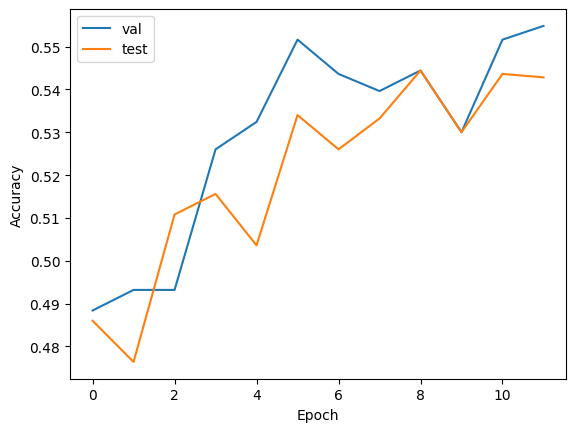

In [9]:
import matplotlib.pyplot as plt

# extract evaluation history of metrics from the evaluator's history property
val_metrics, test_metrics = [], []
for val_metric, test_metric in trainer.evaluator.history:
    val_metrics.append(val_metric['accuracy'])
    test_metrics.append(test_metric['accuracy'])

# plot the performance curves
fig, ax = plt.subplots()
ax.plot(val_metrics, label='val')
ax.plot(test_metrics, label='test')
ax.set(xlabel='Epoch', ylabel='Accuracy')
ax.legend(loc='best')

### 6. Inference with the Trained Model

GraphStorm automatically save the best performaned model according to the value specified in the `save_model_path` argument. We can first find out what is the best model and its path. And then restore it by using model's `restore_model()` method.

In [10]:
# after training, the best model is saved to disk:
best_model_path = trainer.get_best_model_path()
print('Best model path:', best_model_path)

Best model path: a_save_path/epoch-4


In [4]:
# we can restore the model from the saved path using the model's restore_model() function.
model.restore_model(best_model_path)

To do inference, users can either create a new dataloader as the following code does, or reuse one of the dataloaders defined in training.

In [ ]:
# Setup dataloader for inference
infer_dataloader = gs.dataloading.GSgnnNodeDataLoader(dataset=acm_data,
                                                      target_idx=acm_data.get_node_test_set(ntypes=['paper']),
                                                      node_feats=nfeats_4_modeling,
                                                      label_field='label',
                                                      fanout=[100, 100],
                                                      batch_size=256,
                                                      train_task=False)

GraphStorm provides a set of inferrers that can perform highly efficient inference for very large graphs. Similar to trainers, users can create inferrers by given models as input argument, and then call its `infer()` method with a few inference related parameters, such as folder paths for saving inference results.

In [ ]:
# Create an Inferrer object
infer = gs.inference.GSgnnNodePredictionInferrer(model)

# Run inference on the inference dataset
infer.infer(infer_dataloader,
            save_embed_path='infer/embeddings',
            save_prediction_path='infer/predictions',
            use_mini_batch_infer=True)

In [14]:
# The GNN embeddings and predictions on the inference graph are saved to the folder named after the target_ntype
!ls -lh infer/embeddings/paper
!ls -lh infer/predictions/paper

total 640K
-rw-rw-r-- 1 ubuntu ubuntu 626K May  9 22:57 embed-00000.pt
-rw-rw-r-- 1 ubuntu ubuntu  11K May  9 22:57 embed_nids-00000.pt
total 84K
-rw-rw-r-- 1 ubuntu ubuntu 70K May  9 22:57 predict-00000.pt
-rw-rw-r-- 1 ubuntu ubuntu 11K May  9 22:57 predict_nids-00000.pt
